In [102]:
%load_ext autoreload
%autoreload 2

# Shower Temperature Beginner Reinforcement Learning Example

This script implements the Bellman equation to train a Q table and test it.

## Import the shower environment

In [198]:
from shower_environment import Shower
import numpy as np
import matplotlib.pyplot as plt

## Sanity checks on our shower environment

In [118]:
env = Shower()

print("Random valid temperature:", env.observation_space.sample())
print("Random valid temperature change:", env.action_space.sample()-1)

print("\nA few random showers:")
episodes = 5
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        #env.render()
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score+=reward
    print(f"Episode: {episode} Score: {score}")

Random valid temperature: 57
Random valid temperature change: 1

A few random showers:
hello from reset
initial temp: 45
Episode: 1 Score: -10
hello from reset
initial temp: 37
Episode: 2 Score: 40
hello from reset
initial temp: 37
Episode: 3 Score: 6
hello from reset
initial temp: 35
Episode: 4 Score: 4
hello from reset
initial temp: 32
Episode: 5 Score: -14


## Update q table function
* Based on initial and final states
* the action that took us from initial to final, 
* and the reward assigned to the action/final state

In [4]:
def update_q_table(q_table, state_i, state_f, action, step_reward):
    alpha = 0.9  # learning rate
    gamma = 1.0  # discount rate
    epsilon = 0.0  # exploration threshold
    try:
        # note about 2d np array access:
        # q_table[state_i] accesses the state_i-th row, which is an array with
        # length equal to number of actions.
        # q_table[state_i, action] access the action-th element of the state_ith
        # array.
        old_q_value = q_table[state_i, action]
    except IndexError:
        print("ERROR with q_table")
        print(q_table)
        print(state_i, action)
        return None
    
    # max q value given the state after this temp change
    next_max = np.max(q_table[state_f])
    q_target = step_reward + gamma * next_max
    q_delta = q_target - old_q_value
    q_table[state_i, action] = old_q_value + alpha * q_delta
    
    return q_table

## Train and test function
Loop showers, update q table

In [168]:
# loop showers
def train_test(env, in_q_table, n_episodes = 200, do_train = True):
    q_table = in_q_table.copy()
    total_reward = 0
    for i_shower in range(n_episodes):
        done = False
        env.reset()
        state_i = env.state
        shower_reward = 0
        #print(i_shower)
        while not done:
            # choose action
            action = env.action_space.sample() if do_train else np.argmax(q_table[state_i])

            # take a step
            state_f, reward, done, info = env.step(action)
            #print("  ", env.shower_time, state, reward, done)
            try:
                assert state_f in env.observation_space
            except AssertionError:
                print("Invalid state obtained", state_f, i_shower, env.shower_time, action)
                break
                                        
            # update q table
            if do_train:
                q_table = update_q_table(q_table, state_i, state_f, action, reward)

            # increment reward
            shower_reward += reward

            state_i = state_f
            
        #print("  Shower reward:", shower_reward)
        total_reward += shower_reward

    #np.savetxt("qtable.csv", q_table, delimiter=",")
    avg_reward = total_reward / n_episodes
    return q_table, avg_reward

## Train

In [175]:
init_q_table = np.zeros([env.observation_space.n, env.action_space.n])

In [170]:
env = Shower()
q_table, avg_reward = train_test(env, init_q_table, n_episodes = 2, do_train = True)
print(f"average reward: {avg_reward}")

average reward: -33.0


## Test

In [173]:
avg_reward = train_test(env, q_table, n_episodes = 100, do_train = False)[1]
print(f"average reward: {avg_reward}")
avg_reward = train_test(env, q_table, n_episodes = 100, do_train = False)[1]
print(f"average reward: {avg_reward}")
avg_reward = train_test(env, q_table, n_episodes = 100, do_train = False)[1]
print(f"average reward: {avg_reward}")

average reward: -7.42
average reward: 2.06
average reward: -11.0


# Visualize and optimize some parameters

### rewards as a function of training episodes

In [216]:
episodes = range(2,100,2)
rewards = []
for e in episodes:
    env = Shower()
    q_table = train_test(env, init_q_table, n_episodes = e, do_train = True)[0]
    avg_reward = train_test(env, q_table, n_episodes = 100, do_train = False)[1]
    if e % 10 == 0: 
        print(f"{e} training episodes – average reward: {avg_reward}")
    rewards.append(avg_reward)

10 training episodes – average reward: 15.66
20 training episodes – average reward: 41.52
30 training episodes – average reward: 54.04
40 training episodes – average reward: 54.86
50 training episodes – average reward: 54.56
60 training episodes – average reward: 55.72
70 training episodes – average reward: 55.02
80 training episodes – average reward: 55.32
90 training episodes – average reward: 55.46


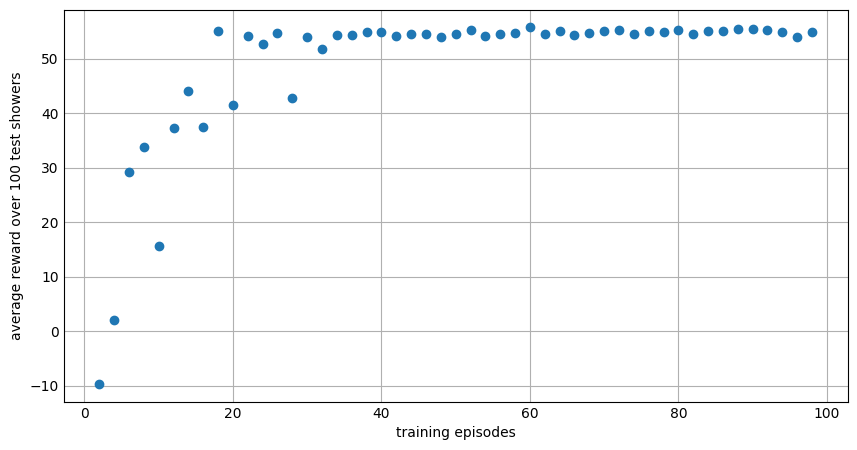

In [217]:
plt.style.use('_mpl-gallery')

fig, ax = plt.subplots(figsize=(8,4))

ax.scatter(episodes, rewards)

plt.ylabel('average reward over 100 test showers')
plt.xlabel('training episodes')

plt.show()